<a href="https://colab.research.google.com/github/borbysh/Momentum-QNG/blob/main/Momentum-QNG_tutorial.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Meet the Quantum Natural Gradient with Momentum (Momentum-QNG) Optimizer

### A 4-minute PennyLane&copy; demo for [Application of Langevin Dynamics to Advance the Quantum Natural Gradient Optimization Algorithm](https://arxiv.org/abs/2409.01978)

## [Oleksandr Borysenko](https://www.linkedin.com/in/alexander-borisenko-4437321bb/), Mykhailo Bratchenko, [Ilya Lukin](https://www.linkedin.com/in/illia-lukin-806656301/), [Mykola Luhanko](https://www.linkedin.com/in/mykola-luhanko-495954243/), [Ihor Omelchenko](https://www.linkedin.com/in/ihor-omelchenko-38839b12a/), [Andrii Sotnikov](https://www.linkedin.com/in/a-g-sotnikov/) and Alessandro Lomi

### 4 min in Colab

<img src="https://github.com/borbysh/Momentum-QNG/blob/main/Santa.png?raw=1" width=384 height=512 />

### *The picture by Yaroslava Borysenko



A Quantum Natural Gradient (QNG) algorithm for optimization of variational quantum circuits has been proposed recently https://quantum-journal.org/papers/q-2020-05-25-269/. In this tutorial, we demonstrate the usage of our new Quantum Natural Gradient with Momentum (Momentum-QNG) optimization algorithm https://arxiv.org/abs/2409.01978. We derived it from the discrete-time Langevin dynamics for a virtual particle in the space of variational parameters. The particle is subject to the QNG force and viscous friction, which results into an additional momentum (inertial) term in the optimizer, compared to the QNG one:

$\Delta \theta_{n+1} = \rho \Delta \theta_{n} - \eta \cdot g^{-1}({\theta_n}) \nabla \mathcal{L}(\theta_n),$

where $\Delta \theta_n$ is a vector of variational parameters' updates at step $n$, $\rho$ is a momentum coefficient, $\eta$ is a learning rate, $g^{-1}({\theta})$ is an inverse of the Quantum Metric Tensor in the variational parameters' space and $\nabla \mathcal{L}(\theta)$ is a vector of gradients of the cost function.

 Similar to other optimization algorithms with the momentum term, such as the Stochastic Gradient Descent with momentum (Momentum) https://www.nature.com/articles/323533a0, Momentum-QNG is more effective to escape local minima and plateaus in the variational parameter space and, therefore, achieves a better convergence behavior, compared to the basic QNG.

 Below we present a short demo, which illustrates a practical application and benchmarking of our Momentum-QNG optimizer

In [17]:
%pip install pennylane

In [18]:
import pennylane as qml
from pennylane import numpy as np

To illustrate the performance of our new optimizer, let's consider the VQE optimization problem aimed to minimize the ground state energy expectation value:

$E(\theta) = \langle 0| U^{\dagger}(\theta) H U(\theta)|0\rangle$,

where $H$ is a Hamiltonian operator, and $U(\theta)$ is a parametrized unitary matrix.

Consider the $N$-qubit quantum Sherrington-Kirckpatrick (SK) model in the transverse field, defined by the following Hamiltonian:

$H = \sum_{(ij)} J_{ij} \sigma_{i}^{z} \sigma_{j}^{z} -g \sum_{i} \sigma_{i}^{x}$,

where the first sum is taken over all pairs of sites $(ij)$ and $J_{ij} = \mathcal{N}(0, 1)/ \sqrt{N}$ are sampled from the normal distribution with zero mean and $1/N$ variance. At small $g < 1.5$ the model is generally in the localized spin glass phase. At large $g$ the model becomes paramagnetic in the $x$ direction.

To make an off-road test drive for the optimizers, we are going to search for the ground state in a strong spin glass regime ($g=10^{-4}$), when the energy landscape  contains local minima.

For the recent discussion of the quantum SK model and its ground state ansatzes see P. M. Schindler, T. Guaita, T. Shi, E. Demler, and J. I. Cirac, Variational Ansatz for the Ground State of the Quantum Sherrington-Kirkpatrick Model
 https://journals.aps.org/prl/abstract/10.1103/PhysRevLett.129.220401

In [19]:
# define parameters in H
N = 8      #number of qubits
rng = np.random.default_rng(seed=12345)
g = 1e-4    #Coupling of the transverse field
ZZ = [qml.PauliZ(i)@qml.PauliZ(j) for i in range(N) for j in range(i+1,N)]
ZZ_coeff = [rng.normal()/np.sqrt(N) for i in range(N) for j in range(i+1,N)]
X = [qml.PauliX(i) for i in range(N)]
X_coeff = [-g for i in range(N)]
# Construct the Hamiltonian
obs = ZZ + X
coeffs = ZZ_coeff + X_coeff
H = qml.Hamiltonian(coeffs, obs, grouping_type="qwc")

The model Hamiltonian is real-valued. Therefore, the wave function ansatz can also be chosen real, consisting only from RY and CNOT gates. As the model contains all-to-all interations, arbitrary pairs of qubits may be potentially entangled. Such an entanglement can be built by application of RY and CNOT gate on the corresponding pair of qubits.

Our ansatz consists of two layers. First, RY and CNOT are applied on every pair of qubits. Second, additional RY rotations are applied on every qubit.



In [20]:
def ansatz(params, qubits):
    pair = 0
    for i in range(qubits-1):
        for j in range(i+1, qubits):
            qml.RY(params[pair], wires = i)
            qml.CNOT(wires=[i, j])
            pair += 1
    for q in range(qubits):
        qml.RY(params[pair+q], wires = q)

In [21]:
dev = qml.device("default.qubit", wires=N)
@qml.qnode(dev)
def cost(x):
    ansatz(x, qubits=N)
    return qml.expval(H)

With the Hamiltomian parameters defined, we are able to calculate the exact ground state energy, to be used below to assess our optimized values:

In [22]:
Eg = H.eigendecomposition['eigval'][0]

Now, we are going to benchmark the performance of four different optimization algorithms. Our first participant is the Quantum Natural Gradient (QNG) optimizer https://quantum-journal.org/papers/q-2020-05-25-269/

In [23]:
def qng_session(params, stepsize=0.07, steps=300):
  opt = qml.QNGOptimizer(stepsize=stepsize, approx='block-diag', lam=0.5)
  old_cost = 9999.9999

  for i in range(steps):
      params = opt.step(cost, params)
      new_cost = cost(params)
      qng_cost.append(100*(Eg - new_cost)/Eg)

      if np.round(old_cost, 5) == np.round(new_cost, 5):
          break
      else:
          old_cost = new_cost
  print("QNG: Ground energy error after step {:5d}: {: .5f}".format(i + 1, 100*(Eg - new_cost)/Eg))
  return params

Our second participant is a modified version of the former, namely the Quantum Natural Gradient with Momentum (Momentum-QNG) optimizer https://arxiv.org/abs/2409.01978, which we introduced above.

In [24]:
def momentum_qng_session(params, stepsize=0.07, momentum=0.9, steps=300):
  opt = qml.MomentumQNGOptimizer(stepsize=stepsize, momentum=momentum, approx='block-diag', lam=0.5)
  old_cost = 9999.9999

  for i in range(steps):
      params = opt.step(cost, params)
      new_cost = cost(params)
      momentum_qng_cost.append(100*(Eg - new_cost)/Eg)

      if np.round(old_cost, 5) == np.round(new_cost, 5):
          break
      else:
          old_cost = new_cost
  print("MomentumQNG: Ground energy error after step {:5d}: {: .5f}".format(i + 1, 100*(Eg - new_cost)/Eg))
  return params

Our third participant is the famous Gradient Descent with Momentum (Momentum) optimizer https://www.nature.com/articles/323533a0

In [25]:
def momentum_session(params, stepsize=0.07, momentum=0.9, steps=300):
  opt = qml.MomentumOptimizer(stepsize=stepsize, momentum=momentum)
  old_cost = 9999.9999

  for i in range(steps):
      params = opt.step(cost, params)
      new_cost = cost(params)
      momentum_cost.append(100*(Eg - new_cost)/Eg)

      if np.round(old_cost, 5) == np.round(new_cost, 5):
          break
      else:
          old_cost = new_cost
  print("Momentum: Ground energy error after step {:5d}: {: .5f}".format(i + 1, 100*(Eg - new_cost)/Eg))
  return params

And, last but not least, our fourth participant is the famous Adam optimizer https://arxiv.org/abs/1412.6980

In [26]:
def adam_session(params, stepsize=0.07, momentum=0.9, steps=300):
  opt = qml.AdamOptimizer(stepsize=stepsize, beta1=momentum, beta2=0.99, eps=1e-08)
  old_cost = 9999.9999

  for i in range(steps):
      params = opt.step(cost, params)
      new_cost = cost(params)
      adam_cost.append(100*(Eg - new_cost)/Eg)

      if np.round(old_cost, 5) == np.round(new_cost, 5):
          break
      else:
          old_cost = new_cost
  print("Adam: Ground energy error after step {:5d}: {: .5f}".format(i + 1, 100*(Eg - new_cost)/Eg))
  return params

Now, we are ready to benchmark the four algorithms described above by running the VQE optimization task of the Sherrington-Kirkpatrick model introduced earlier, with the same initial conditions, picked from the random generator with a continuous uniform distribution over the [0.0, 1.0) interval. For Adam, Momentum and Momentum-QNG we take the same momentum=0.9 and for all the four we take the same stepsize=0.5

In [27]:
iterations=300
stepsize = 0.5
momentum=0.9

qng_cost = []
momentum_qng_cost = []
momentum_cost = []
adam_cost = []
np.random.seed(seed=12345)
num_params = int(N*(N+1)/2)
init_params = 0.1*np.random.random(size = num_params)

print(f"Exact ground state energy is: {Eg:.4f}")
params_qng = qng_session(init_params, stepsize, iterations)
params_momentum_qng = momentum_qng_session(init_params, stepsize, momentum, iterations)
params_momentum = momentum_session(init_params, stepsize, momentum, iterations)
params_adam = adam_session(init_params, stepsize, momentum, iterations)

Exact ground state energy is: -4.2174
QNG: Ground energy error after step    50:  30.75399
MomentumQNG: Ground energy error after step   106:  0.00137
Momentum: Ground energy error after step    71:  0.10423
Adam: Ground energy error after step    72:  0.06427


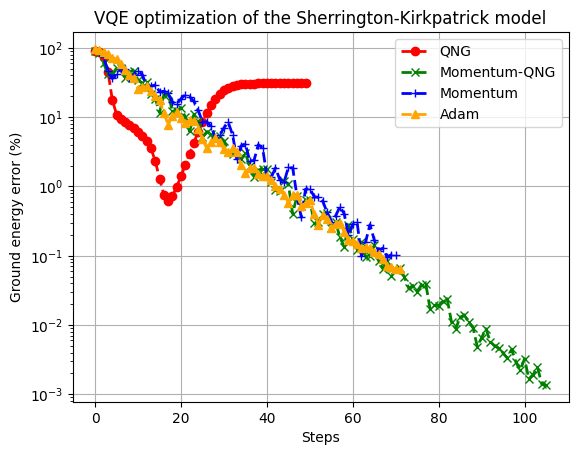

In [28]:
import matplotlib.pyplot as plt

label_1 = 'QNG'
label_2 = 'Momentum-QNG'
label_3 = 'Momentum'
label_4 = 'Adam'

plt.plot(qng_cost, color='r', marker='o', linestyle='--', linewidth = 2.0, label=label_1)
plt.plot(momentum_qng_cost, color='g', marker='x', linestyle='--', linewidth = 2.0, label=label_2)
plt.plot(momentum_cost, color='b', marker='+', linestyle='--', linewidth = 2.0, label=label_3)
plt.plot(adam_cost, color='orange', marker='^', linestyle='--', linewidth = 2.0, label=label_4)



plt.title('VQE optimization of the Sherrington-Kirkpatrick model')
plt.xlabel('Steps')
plt.ylabel('Ground energy error (%)')
plt.legend(loc='upper right')
plt.grid()
plt.yscale('log')

plt.show()

One can see that, for the initial conditions chosen, Momentum-QNG achieves the least ground energy error, Momentum and Adam stick to some higher local minima, while the momentumless QNG demonstrates a prominent overfitting behavior. Therefore, combination of the nonzero momentum (or inertial) term, applied in the Momentum algorithm with the quantum metric tensor, applied in the QNG algorithm, can result in a synergetic effect (if you are lucky;-)

###Acknowledgement:
O.B., M.B. and I.O. have received funding through the EURIZON project, which is funded by the European Union under grant agreement No.871072. I.L. and A.S. acknowledge support by the National Research Foundation of Ukraine, project No. 2023.03/0073.